# Optimized gauge transformation

## The goal of this notebook is to perform the gauge transformation in an optimized way inside the temporal loop so we can later move it to the GPU

### Set parametres and eviroment variables

In [19]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2      
N = 64   
tau_sim = 1     
DTS = 8     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# TODO: Run more events
nevents = 1

In [20]:
import os

# I need to add this line to ask resources from a specific GPU, which is free. Our GPU server has no queing system
os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
# Number of colors
Nc = su.NC
# Dimension of algebra 
Dg = su.GROUP_ELEMENTS

### We define the simulation routine

In [46]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(): 
    # output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Plus gauge link
    uplus_LC = su.GROUP_TYPE(np.zeros((maxt//DTS, N, N, Dg)))
    v_LC = su.GROUP_TYPE([[[su.unit() for z in range (N)] for y in range(N)] for xplus in range (maxt//DTS)])

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Copy gauge links and gauge fields from the memory of the GPU
            if t%DTS == 0:
                u1 = s.u1.copy()
                u0 = s.u0.copy()
                
                ux_act = u1[:,0,:].reshape(N,N,Dg)
                ux_prev = u0[:,0,:].reshape(N,N,Dg)
                
                ae_act = s.aeta1.copy().reshape(N, N, Dg)
                ae_prev = s.aeta0.copy().reshape(N, N, Dg)
                
                # We construct the u_+ links over the x^+ axis in a (y,z) transverse lattice
                uplus_temp = su.GROUP_TYPE(np.zeros((N,N,Dg)))
                
                for y in range(N):
                    for z in range(N):
                        uplus_temp[y, z] = su.mul(su.mexp(su.mul_s(ae_prev[t//DTS, y], 1j*g*a*(z-N//2))), ux_prev[t//DTS, y])
                
                
                # We construct the gauge operator and transform the field
                for xplus in range(maxt//DTS):
                    for y in range(N):
                        for z  in range(N):
                            
                            if xplus > t: # We construct the gauge operator
                                v_prev = v_LC[xplus, y, z]
                                umin = su.mul(su.mexp(su.mul_s(ae_act[2*xplus-t//DTS, y], 1j*g*a*(z-N//2))), su.dagger(ux_act[t//DTS, y]))
                                v_LC[xplus, y, z] = su.mul(umin, v_prev)
                                
                            elif xplus == (t//DTS) and xplus != 0:
                                uplus_LC[xplus, y, z] = su.mul(su.mul(su.dagger(v_LC[xplus, y, z]), uplus_temp[y,z]), v_LC[xplus-1, y, z])
                                
                
            
            
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return uplus_LC #ux2 #, uy, aeta

In [47]:
# Supress various horribly long warnings
import warnings
warnings.filterwarnings('ignore')

In [48]:
uplus_LC = simulate()

Kernel xi: 0 d:  0 did not reach goal. check:  0.000820588239270005
Kernel xi: 0 d:  1 did not reach goal. check:  0.03893405214999626
Kernel xi: 1 d:  0 did not reach goal. check:  0.0022105649370088047
Kernel xi: 1 d:  1 did not reach goal. check:  0.059247558477875904
Kernel xi: 2 d:  0 did not reach goal. check:  0.018059376082573575
Kernel xi: 2 d:  1 did not reach goal. check:  0.04268084615989132
Kernel xi: 3 d:  0 did not reach goal. check:  0.022746217009882518
Kernel xi: 3 d:  1 did not reach goal. check:  0.0308020987173507
Kernel xi: 4 d:  0 did not reach goal. check:  0.009432205273253037
Kernel xi: 4 d:  1 did not reach goal. check:  0.036582758557763016
Kernel xi: 5 d:  0 did not reach goal. check:  0.011686134895453414
Kernel xi: 5 d:  1 did not reach goal. check:  0.03376466279752419
Kernel xi: 6 d:  0 did not reach goal. check:  0.01018200741752818
Kernel xi: 6 d:  1 did not reach goal. check:  0.005217242317647538
Kernel xi: 7 d:  0 did not reach goal. check:  0.0082

100%|██████████| 256/256 [00:03<00:00, 80.79it/s] 


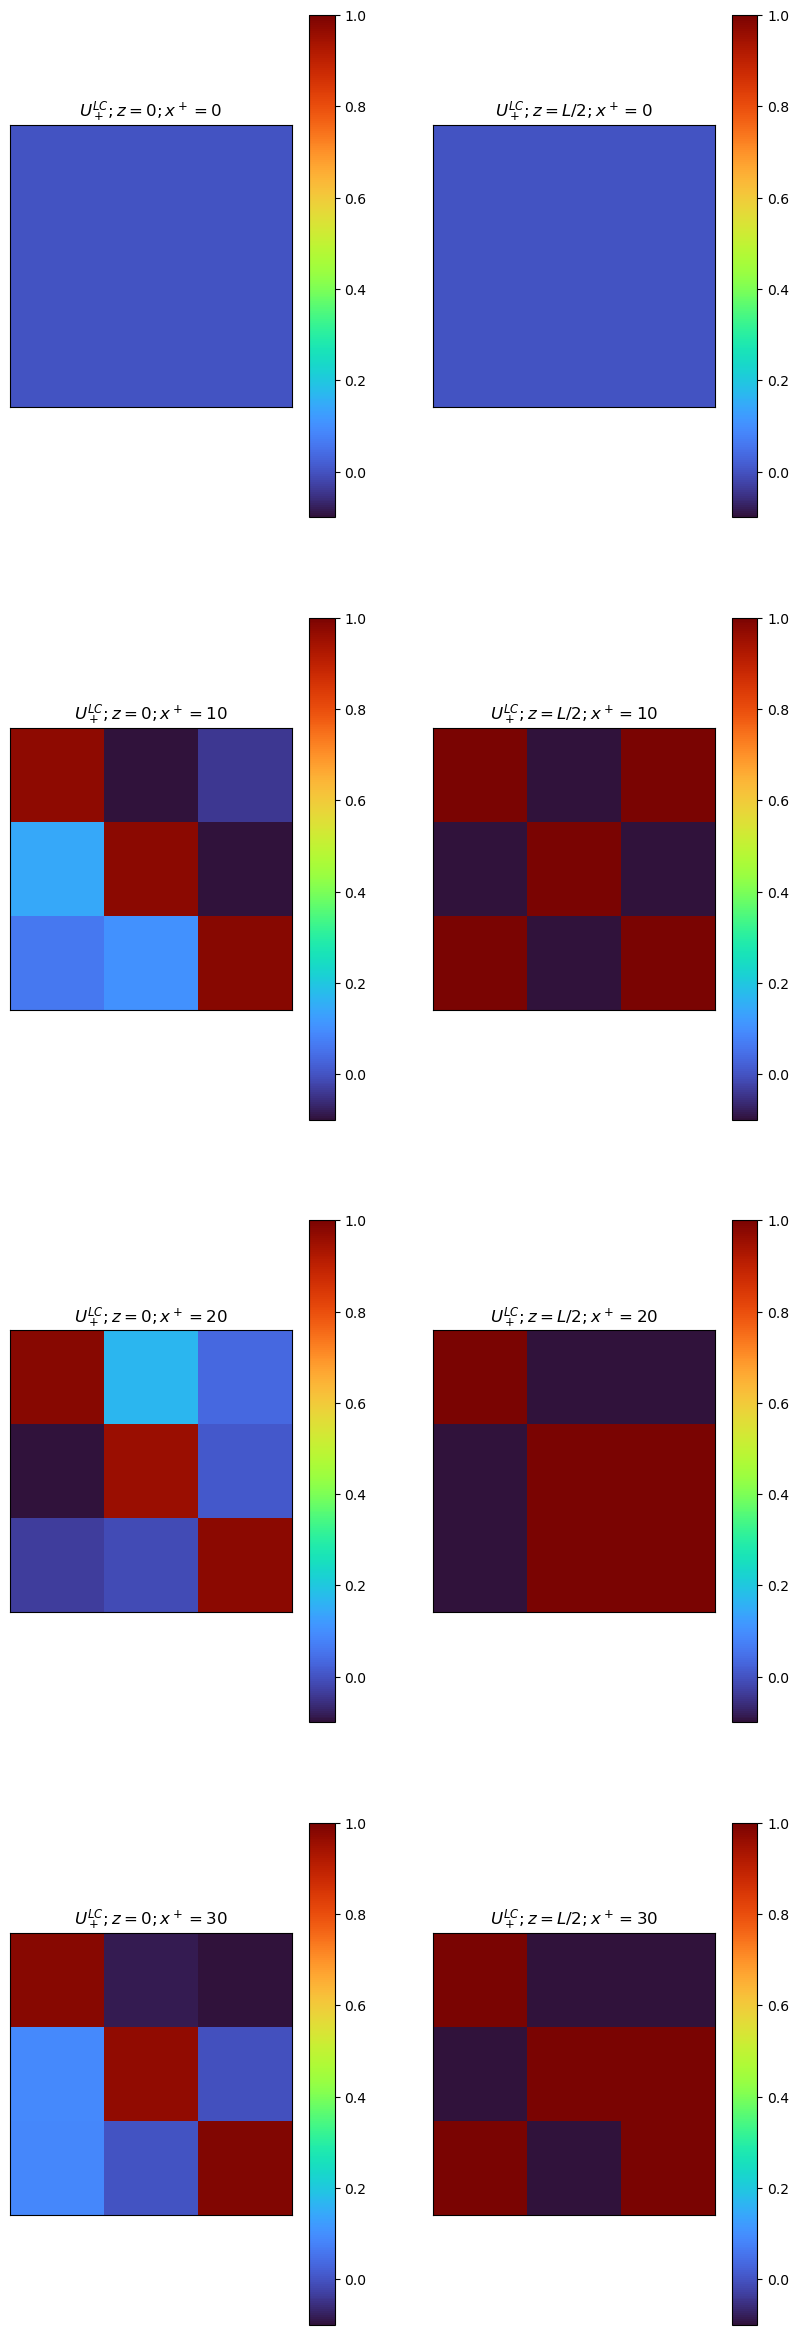

In [49]:
import matplotlib.pyplot as plt 

t_steps = int(tau_sim*N / L)
y = N//2

uplus_LC_plot = uplus_LC.reshape(t_steps, N, N, 3, 3)

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(uplus_LC_plot[tau, y, N//2, :, :].real, cmap='turbo', vmin=-0.1, vmax=1) 
    axs[t,0].set_title(r'$U_+^{LC}; z =0; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(uplus_LC_plot[tau, y, 0, :, :].real, cmap='turbo', vmin=-0.1, vmax=1)
    axs[t,1].set_title(r'$U_+^{LC}; z = -L/2; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)